# DETECTRON2

This is a short guide of Detectron2, Facebook AI Research's library with state-of-the-art detection and segmentation algorithms. It supports a number of computer vision research projects and production applications in Facebook. It has been used to implement the instance segmentation model for this project: Mask R-CNN ([He et al., 2017](#https://arxiv.org/abs/1703.06870))

[Documentation](#https://detectron2.readthedocs.io/en/latest/)  
[Github](#https://github.com/facebookresearch/detectron2)

## 0. Install

Requirements (February 2022): 
- Linux or macOS with Python ≥ 3.6
- PyTorch ≥ 1.8, with matching torchvision 
- Opencv
- Gcc & G++ ≥ 5.4

Official tutorial: [Link](#https://detectron2.readthedocs.io/en/latest/tutorials/install.html)  
Official installation instructions: [Link](#https://detectron2.readthedocs.io/en/latest/tutorials/install.html)

In [ ]:
# Check versions
! python --version
! python3 --version 
! pip --version 
! pip3 --version
! pwd

In [ ]:
# Create a virtual environment and install the necessary libraries
"""
conda create -n envir python==3.9.0
conda activate envir 
python3 -m pip install --upgrade pip
pip install opencv-python
pip install pyyaml==5.1
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
gcc/g++ --version
CC=clang CXX=clang++ ARCHFLAGS="-arch x86_64" python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
conda install ipykernel
"""

## 1. Import
[Cuda - Torch](#https://pytorch.org/docs/stable/cuda.html)

In [1]:
import torch
import numpy as np 
import pandas as pd
import os, json, cv2, random, time, datetime
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

print('>>> CUDA Information')
print('torch version: ', torch.__version__)
print('cuda version: ', torch.__version__.split("+")[-1])

print('CUDA is currently available: ', torch.cuda.is_available()) 
print('number of GPUs available: ', torch.cuda.device_count())
print('GPUs names: ', [torch.cuda.get_device_name(gpu) for gpu in range(torch.cuda.device_count())])
print('GPUs capbilities: ', [torch.cuda.get_device_capability(gpu) for gpu in range(torch.cuda.device_count())])
print('GPUs properties:')
print('\n'.join([str(torch.cuda.get_device_properties(gpu)) for gpu in range(torch.cuda.device_count())]))

# Setup detectron2 logger
import detectron2
import logging
from detectron2.utils.logger import setup_logger, log_every_n_seconds
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.data import print_instances_class_histogram, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, inference_context, print_csv_format

from detectron2.engine.hooks import HookBase
import detectron2.utils.comm as comm
from detectron2.utils.visualizer import Visualizer, ColorMode, VisImage
from detectron2.utils.analysis import parameter_count_table, parameter_count

# Apple - download external links
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
print()
print('>>> Library correctly imported')

###############################################################################################################
# DIRECTORIES: @@@ OVERRIDE: Paths to train and validation images and annotations
dir_tr = 'train/images'
dir_val = 'validation/images'
dir_tr_json = 'train/annos_train.json'
dir_val_json = 'validation/annos_val.json'
dir_te = 'test/images'
dir_te_json = 'test/annos_test.json'

OUTPUT_DIR = '.../output_experimentX' # Path of folder where training outputs have been saved
img_path = '.../000000.jpg' # Path of a test image 

>>> CUDA Information
torch version:  1.10.2
cuda version:  1.10.2
CUDA is currently available:  False
number of GPUs available:  0
GPUs names:  []
GPUs capbilities:  []
GPUs properties:




>>> Library correctly imported


## 2. Dataset

Detectron2 offers a few builtin datasets ([COCO](#https://cocodataset.org/#download), [LVIS](#https://www.lvisdataset.org/dataset), [CITYSCAPES](#https://www.cityscapes-dataset.com/login/), [PASCAL VOC](#http://host.robots.ox.ac.uk/pascal/VOC/index.html) and [ADE20K Scene Parsing](#http://sceneparsing.csail.mit.edu/)). Each dataset is defined by two objects: ```DatasetCatalog```, to access its data, and ```MetadataCatalog```, to access its metadata (class names, etc).
DatasetCatalog is a global dictionary that stores information about the datasets and how to obtain them. It contains a mapping from strings (which are names that identify a dataset, e.g. “coco_2014_train”) to a function which parses the dataset and returns the samples in the format of list[dict], 1 dict per each image. The purpose of having this catalog is to make it easy to choose different datasets, by just using the strings in the config. MetadataCatalog is as well a global dictionary that provides access to Metadata of a given dataset.
The metadata associated with a certain name is a singleton: once created, the metadata will stay alive and will be returned by future calls.

To use a custom dataset, it's necessary to register its data and metadata in the two global catalogs. If the dataset is already a json file in the COCO format, the dataset and its associated metadata can be registered easily with ```register_coco_instances()```. 

In this project I have separately converted VIA json annotations into COCO format. 

In [ ]:
# Create a Dataset: Register Dataset COCO FORMAT
register_coco_instances("train_set", {}, dir_tr_json, dir_tr)
register_coco_instances("val_set", {}, dir_val_json, dir_val)

dataset_train = DatasetCatalog.get('train_set')
dataset_val = DatasetCatalog.get('val_set')

meta_train = MetadataCatalog.get('train_set') 
meta_val = MetadataCatalog.get('val_set')

**DatasetCatalog**  
To access the actual dataset use the method ```get()```: it returns a list of dictionaries, one dict per one image.   
Each dictionary stores [some information](#https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts) relative to each image, such as the annotations.  
For each image the annotations are saved in a list of dictionaries, one per instance. 

    1 image => 1 dict    
    1 image => x annotations  
    1 annotation => 1 instance => z polygons  

For each annotation the following information are retrieved: 
1. Category Id: an integer in the range **[0, num_categories-1]** representing the category label. The value num_categories is reserved to represent the “background” category, if applicable. Note: in other instance segmentation libraries the category 0 corresponds to the background!!
2. Bounding Box: list of 4 numbers.
3. Bounding Box Mode: the format of the bbox, XYXY (0) or XYWH (1).
4. Segmentation: a list of polygons [[x1, y1, ..., xn, yn], [x1, y1, ..., xn, yn]], one for each connected component of the object, that define 1 object instance. If the list has len == 1 it means that 1 polygon is sufficient to contain the whole instance.
5. Keypoints: list of keypoints [x1, y1, v1,…, xn, yn, vn] where n is the number of keypoints categories. In this project they are not considered.
6. Is crowd: 1 if this instance is labeled as COCO’s “crowd region”. In this project it's always 0. 
 
**MetadataCatalog**  
To access the actual metadata use the method ```get()```: it returns a metadata object, a key-value mapping that contains [information](#https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#metadata-for-datasets) that’s shared among the entire dataset, and usually is used to interpret what’s in the dataset, e.g., names of classes, colors of classes, root of files, etc.  
In this case the metadata are: 
1. Name: dataset name. 
2. Json file: directory of json file.
3. Image root: directory of folder with images.
4. Evaluator type: default evaluator for this dataset, COCO in this case. To understand what an evaluator is read the training section. 
5. Thing classes: a list of names for each instance/thing category.
6. Thing dataset id to contiguous id: a mapping from instance class ids in the dataset to contiguous ids in range [0, #class). Available only for COCO format dataset. 

In [ ]:
# DatasetCatalog
show = False
assert type(dataset_train) == type(dataset_val) == list
if show: print('>>> A dataset of N images is a list of N dictionaries.\nEach dictionary stores:\n', list(dataset_train[0].keys()),'\nEach annotation stores:\n',list(dataset_train[0]['annotations'][0].keys()))

if show: # Example of 1 annotation
    print('\n>>> Example of annotation: ')
    for k,v in dataset_train[0]['annotations'][0].items():
        print('\n{}: {}'.format(k,v)) 

# MetadataCatalog
assert type(meta_train) == type(meta_val) == detectron2.data.catalog.Metadata
metadata = [meta_val.name, meta_val.json_file, meta_val.image_root, meta_val.evaluator_type, meta_val.thing_classes, meta_val.thing_dataset_id_to_contiguous_id]
if show: print('\n>>> Example of metadata:', '\n'.join([str(i) for i in metadata]))

In [ ]:
# Get dataset category distribution 
print_instances_class_histogram(dataset_train, meta_train.thing_classes)

## 3. Training

**TRAINING WORKFLOW**  
Detectron2 offers three possibilities to build a training loop: 
1. Built it from scratch: ideal to manage the entire training logic more clearly and have full control (following the [example](#https://github.com/facebookresearch/detectron2/blob/main/tools/plain_train_net.py)).
2. Use [```SimpleTrainer```](#https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.SimpleTrainer): ideal to have a minimal loop on top of which implementing other tasks (such as checkpointing, logging, evaluation).
3. Use [```DefaultTrainer```](#https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.defaults.DefaultTrainer): ideal to have a standard training workflow already implemented with few common standard tasks. 

In this project I use a DefaultTrainer since I need just a standard training loop. However, I implement others tasks using the [hook system](#https://detectron2.readthedocs.io/en/latest/modules/engine.html#detectron2.engine.HookBase): in short, it allows users to code inside the DefaultTrainer class new methods, called 'hooks', that execute at each training step some tasks.

**Default Trainer**  
The ```DefaultTrainer``` object is initialized from a [yacs](#https://github.com/rbgirshick/yacs) configuration that stores the configurable model hyperparameters, such as the model weights and the network components, and some other configurable training parameters, such as the number of iterations, learning rate, batch size, path to train set.  
Detectron2 offers a default yacs configuration, ```CfgNode```, that can be customized by adding new variables or changing existing ones. It stores the architecture of [Base-RCNN-FPN](#https://github.com/facebookresearch/detectron2/blob/main/configs/Base-RCNN-FPN.yaml), a standard Faster R-CNN with ResNet50 as backbone, a Region Proposal Network and a Box Head.  
Each pre-trained baseline model available in [model_zoo](#https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) is defined by a yacs config file. Using the method ```CfgNode.merge_from_file()```, the default detectron2 yacs configuration loads content from the config file of a given pre-trained model and merges it into itself. In this way it's possible to tarnsform the basic Base-RCNN-FPN into the pre-trained model, upload pre-trained weights and do transfer learning or inference with a custom dataset.  

As mentioned above, DefaultTrainer builts a standrad training workflow:
1. Build model: build the whole model architecture, defined by ```cfg.MODEL.META_ARCHITECTURE``` but doesn't load any weights from cfg.
2. Build optimizer: build an optimizer from cfg parameters. 
3. Build train dataloader: a dataloader is a component that takes raw information from datasets, and process them into a format needed by the model.
4. Build scheduler: build a Learning Rate scheduler from cfg parameters. 
5. Build checkpointer: a checkpointer saves any checkpointable objects, such as the model architecture, during training.
6. Build Hooks: a hook is a fucntion that mantains during training some tasks. DefaultTrainer builds a list of default hooks, including (in this order):
    - timing (```hooks.IterationTimer()```): tracks the time spent for each iteration and prints a summary in the end of training.
    - lr scheduling (```hooks.LRScheduler()```): executes a the previously-built LR scheduler and summarizes the LR after every iteration.
    - precise BN (```hooks.PreciseBN```): computes the true average of statistics (over the last 200 iterations) rather than the moving average, and updates every BatchNorm layer in the given model by these precise averages, periodically (every ```cfg.TEST.EVAL_PERIOD ``` iterations) and after the last iteration.
    - checkpointing (```hooks.PeriodicCheckpointer()```): saves checkpoints periodically (every 5000 iterations) and after the last iteration.
    - evaluation (```hooks.EvalHook()```): runs an evaluation function (that evaluates the weights of the model on the validation set and return some metrics) periodically (every ```cfg.TEST.EVAL_PERIOD``` iterations) and after the last iteration. If ```cfg.TEST.EVAL_PERIOD``` = 0, it runs only after the last iteration.
    - writing events (```hooks.PeriodicWriter()```): writes events to EventStorage (the object where training metrics are stored) periodically (every 20 iterations) and then prints common metrics on the final ```metrics.json``` file. 
7. Register Hooks: hooks are executed in the order they are registered.

Once everthing is built, two functions are called to start the training. First, ```result_or_load()``` that either loads the model pre-trained weights and starts an independent training or redume the training from the last checkpoint. Then ```train()``` to actually start the training loop.

**TRAINING MODELS**    
The base model provided by defualt is the Base-RCNN-FPN. Its architecture is based on three components: a backbone, a region proposal generator and some ROI heads. As mentioned above, it's possible to customize this basic network to transform it in any other model that shares its same structure.   
Detectron2 offers different built-in architectures to customize any model. They are accessible through the [model registries](#https://detectron2.readthedocs.io/en/latest/modules/modeling.html#model-registries). Each registry provides the ability to replace a part or the whole model with a customized component, without having to modify directly detectron2's code.

<font size="1">

|Registry Name|Network Part|Function|
|---|---|---|
| Meta Architectures | whole model | depends on the architecture |
| Backbone | backbone | to extract feature maps from images |
| Proposal Generator | RPN | to produce object proposals from feature maps |
| RPN Head | RPN | to take feature maps and perform objectness classification and bounding box regression for anchors |
| Anchor Generator | RPN | to create object detection anchors for feature maps |
| ROI Heads| ROI Heads | to take feature maps and region proposals, and perform per-region computation depending on the heads|
| ROI Box Head | ROI Heads | to predict bbox from per-region features |
| ROI Mask Head | ROI Heads | to predict instance masks from per-region features |
| ROI Keypoint Head | ROI Heads | to predict keypoints from per-region features |

</font>

In this project I need a pre-trained Mask-RCNN. From model_zoo, the best-performing ones are: 
- [X101-FPN](#https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml) - COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml
- [R101-FPN](#https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml) - COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml 

They are both trained on COCO 2017 and share the same architecture with:
1. Backbone: CNN and Feature Pyramid Network
2. Region Proposal: Region Proposal Network
3. ROI Heads: Box Head and Mask Head  

The only difference between them is the CNN in the backbone: ResNetXt in the first and ResNet in the second. ResNetXt has building blocks with convolutional layers not just in sequence, as in ResNet, but also in parallel, as in Google's Inception module.
Given the small difference in mask prediction's accuracy and the bigger difference in training time, I opted for R101-FPN. To understand the difference between the default base configuration and the two above-mentioned Mask R-CNN, look at the code below that does a comparison. 

### 4.0. Explore Model registries

In [ ]:
from detectron2.modeling import (
    META_ARCH_REGISTRY, BACKBONE_REGISTRY, PROPOSAL_GENERATOR_REGISTRY, RPN_HEAD_REGISTRY, ANCHOR_GENERATOR_REGISTRY, 
    ROI_HEADS_REGISTRY, ROI_BOX_HEAD_REGISTRY, ROI_MASK_HEAD_REGISTRY, ROI_KEYPOINT_HEAD_REGISTRY
)

META_ARCH_REGISTRY

### 4.1. Explore difference between models' configurations 

<font size="1">

|| parameter name|DEFAULT - BASE_RCNN_FPN|MASK_RCNN_RESNET101|MASK_RCNN_RESNETXT101|
|--- | --- | --- | --- | --- |
|GENERAL|| | |
|TEST|| | |
|DATA|min_size_train |800|640, 672, 704, 736, 768, 800| ""|
| | Train | | coco_2017_train | ""
|| Test ||coco_2017_val|""
|SOLVER|max_iter| 40k| 270k|""|
|| base_lr |0.001|0.02|""|
|| steps |30k|210k, 250k | ""
|MODEL|MASK_ON|	False	|True | ""
||WEIGHTS |||
||PIXEL_STD	|[1.0, 1.0, 1.0]|[1.0, 1.0, 1.0]	|[57.375, 57.12, 58.395]
||BACKBONE.NAME	|build_resnet_backbone	|build_resnet_fpn_backbone | ""
||FPN.IN_FEATURES|	[]|	['res2', 'res3', 'res4', 'res5'] |""
||ANCHOR_GENERATOR.SIZES|	[[32, 64, 128, 256, 512]]	|[[32], [64], [128], [256], [512]] | ""
||RPN.IN_FEATURES|	['res4']|	['p2', 'p3', 'p4', 'p5', 'p6'] | ""
||RPN.PRE_NMS_TOPK_TRAIN|	12k|	2k | ""
||RPN.PRE_NMS_TOPK_TEST	|6k	|1k | ""
||RPN.POST_NMS_TOPK_TRAIN |2k	|1k | ""
||ROI_HEADS.NAME|	Res5ROIHeads|	StandardROIHeads| ""
||ROI_HEADS.IN_FEATURES	|['res4']	|['p2', 'p3', 'p4', 'p5']| ""
||ROI_BOX_HEAD.NAME	||	FastRCNNConvFCHead| ""
||ROI_BOX_HEAD.POOLER_RESOLUTION|	14	|7| ""
||ROI_BOX_HEAD.NUM_FC|	0	|2| ""
||ROI_MASK_HEAD.NUM_CONV|	0	|4| ""
||RESNETS.DEPTH	|50	|101| ""
||RESNETS.OUT_FEATURES|	['res4']|	['res2', 'res3', 'res4', 'res5']| ""
||RESNETS.NUM_GROUPS	|1|1|	32
||RESNETS.WIDTH_PER_GROUP|64|	64|	8
||RESNETS.STRIDE_IN_1X1 |True|True|	False

</font>



In [ ]:
def explore_cfg(config):
    flat_cfg = {}
    for name in list(config):
        try:
            d = {}
            for k, v in dict(config[name]).items():
                if isinstance(v, detectron2.config.config.CfgNode):
                    for a,b in dict(v).items():
                        d[k+'.'+a] = b
                else: 
                    d[k] = v
            flat_cfg[name] = d
        except:
            flat_cfg[name] = config[name]

    # Create dataframes for better visualization
    a = {name :flat_cfg[name] for name in ['VERSION', 'GLOBAL',  'OUTPUT_DIR',  'SEED', 'CUDNN_BENCHMARK', 'VIS_PERIOD']}
    b = {name : flat_cfg[name] for name in ['INPUT', 'DATASETS', 'DATALOADER']}
    c = {k:str(v) if type(v) in [dict, list, tuple] else v for k,v in flat_cfg['SOLVER'].items()}
    d = {k:str(v) if type(v) in [dict, list, tuple] else v for k,v in flat_cfg['TEST'].items()}
    e = {k:str(v) if type(v) in [dict, list, tuple] else v for k,v in flat_cfg['MODEL'].items()}

    dfs_cfg = {}
    dfs_cfg['general'] = pd.DataFrame(a)
    dfs_cfg['data'] = pd.DataFrame(b).fillna('')
    dfs_cfg['solver'] = pd.DataFrame.from_dict(c, orient='index', columns=['parameter'])
    dfs_cfg['test'] = pd.DataFrame.from_dict(d, orient='index', columns=['parameter'])
    dfs_cfg['model'] = pd.DataFrame.from_dict(e, orient='index', columns=['parameter'])

    return flat_cfg, dfs_cfg

def compare_configs(model_configs_df:list, model_names:list, k:str):
    for i in range(len(model_configs_df)):
        for j in range(i+1, len(model_configs_df)):
            print('COMPARE {}: {}  vs  {}'.format(k.upper(), model_names[i], model_names[j]))
            display(model_configs_df[i][k].compare(model_configs_df[j][k]))

In [ ]:
# Compare configurations of Det2 Base Model - MaskRCNN R101 - MaskRCNN X101: Instantiate configs
defcfg = get_cfg()

r101cfg_name = 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
r101cfg = get_cfg() 
r101cfg.merge_from_file(model_zoo.get_config_file(r101cfg_name))
r101cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(r101cfg_name)

x101cfg_name = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
x101cfg = get_cfg() 
x101cfg.merge_from_file(model_zoo.get_config_file(x101cfg_name))
x101cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(x101cfg_name)

# Save configs as a dictionary and create dataframes
flat_defcfg, defcfg_dfs = explore_cfg(defcfg)
flat_r101cfg, r101cfg_dfs = explore_cfg(r101cfg)
flat_x101cfg, x101cfg_dfs = explore_cfg(x101cfg)
print('AVAILABLE KEYS: ', defcfg_dfs.keys())

# Pick a key and show differences
k = 'general'
c = [defcfg_dfs, r101cfg_dfs, x101cfg_dfs]
names = ['default', 'maskrcnn R101-FPN', 'maskrcnn X101-FPN']
compare_configs(c, names, k)

### 4.2. Training


**TRAINING PARAMETERS**  
Parameters to change in the training configuration: 
<font size="1">

|NAME| DEFAULT - BASE_RCNN_FPN|MASK_RCNN_RESNET101|MASK_RCNN_RESNETXT101| my choice |
| --- | ---| ---| --- | --- |
|DATASETS.TRAIN | () | COCO 2017 Train | "" | deepfashion2 Train
|DATASETS.TEST | () | COCO 2017 Validation | "" | deepfashion2 Validation
|TEST.EVAL_PERIOD| 0 | 0 | "" | 5k
|SOLVER.MAX_ITER | 40k | 270k | "" | 50k
|SOLVER.STEPS| (30k, ) | (210k, 250k) | "" | (10k, 25k)
|ROI_HEADS.NUM_CLASSES| 80| 80| ""| 13

</font>


In [ ]:
# Register Datasets
register_coco_instances("train_set", {}, dir_tr_json, dir_tr)
register_coco_instances("val_set", {}, dir_val_json, dir_val)

dataset_train = DatasetCatalog.get('train_set')
dataset_val = DatasetCatalog.get('val_set')

meta_train = MetadataCatalog.get('train_set')
meta_val = MetadataCatalog.get('val_set')

In [ ]:
# Create Training Configuration 
cfg_name = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
cfg = get_cfg() 
cfg.merge_from_file(model_zoo.get_config_file(cfg_name))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_name)

cfg.DATASETS.TRAIN = ("train_set",)           # default: (coco2017_train)
cfg.DATASETS.TEST = ("val_set",)              # default: (coco2017_val)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

cfg.TEST.EVAL_PERIOD = 5000                   # default: 0
cfg.SOLVER.MAX_ITER = 50000                   # default: 270k - adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (10000, 25000)             # default: (210k, 250k) - iteration number to decrease learning rate by GAMMA.

# Save configuration file 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(os.path.join(cfg.OUTPUT_DIR, "model_config.yaml"), "w") as f:
  f.write(cfg.dump())

In [ ]:
# Update Default Trainer instance: add 1 hook and validation evaluator
class LossEvalHook(HookBase):
    """Computes the validation loss and add it to other default metrics.
    Source: github @ortegatron/LossEvalHook.py"""
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
           
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

class FashionTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """Override main method to feed the evaluation hook with a DatasetEvaluator.
        In the DefaultTrainer this method is not implemented. Hence no inference 
        on the validation set is performed during training.

        COCOEvaluator is choosen as a DatasetEvaluator: it computes metrics 
        using standard COCO APIs on the cfg.DATASETS.TEST."""
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "val_inference")
            os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, True, output_folder) 
                     
    def build_hooks(self): 
        """Override main method to add 1 hook to compute validation loss"""
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(cfg.TEST.EVAL_PERIOD, self.model,
            build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0], DatasetMapper(self.cfg,True))
        ))
        return hooks

In [ ]:
# Train! (WORKS ONLY WITH GPU)
trainer = FashionTrainer(cfg)  
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
trainer.model # Get the model architecture 
trainer.optimizer # Get the model optimizer (SGD)

# Count model's parameters 
print(parameter_count_table(trainer.model)) # aproximate numbers
parameter_count(trainer.model) # Get exact number for each layer

### 4.3. Evaluation

**Training Output files**
- output/
    - ```events.tf.```: file with tensorboard events
    - ```last_checkpoint```: file with the file name of the most recent model_*.pth
    - ```some model_*.pth```: files saved at different iterations with weights for each layer
    - ```metrics.json```: file with information about model performance (every 20 iterations) and about evaluation on validation set (every cfg.TEST.EVAL_PERIOD iterations)
    - val_inference/: output directory of COCOEvaluator (the build_evaluator method implemented in DefaultTrainer object)
        - ```instances_predictions.pth```: a file that can be loaded with `torch.load()` and contains all the predictions for each image of the validation set in the format they are produced by the model (K category ids from 0 to K-1). In COCO there's a default limit on the number of detections per image, equal to 100. 
        - ```coco_instances_results.json```: a json file in COCO's result format (K category ids from 1 to K) with same predictions.

As mentioned above, during training the trainer performs inference on the validation set. It predicts the outputs for each image in the validation set. Then, using the function ```inference_on_dataset()``` it's possible to call an evaluator to process the predictions. Te evaluator used in this project is [```COCOEvaluator```](#https://detectron2.readthedocs.io/en/latest/modules/evaluation.html?highlight=cocoevaluator#detectron2.evaluation.COCOEvaluator). It computes the standard COCO's metrics for the model's detection tasks. In the case of instance detection and segmentation it provides the so-called mean average precision mAP at different IOU thresholds. Important: the metrics range from 0 to 100 (instead of 0 to 1), where a -1 or NaN means the metric cannot be computed (e.g. due to no predictions made). These metrics are saved in the metrics.json file. 

To get the same metrics, without accessing the json file, it's possible to re-run the inference on the validation set. The resulting metrics will be the same of those saved in the json file. 

In [ ]:
# Re-evaluate the validation set
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val_set", cfg, False, output_dir=os.path.join(cfg.OUTPUT_DIR, "val_inference")) # initialize an evaluator
val_loader = build_detection_test_loader(cfg, "val_set") # initialize val dataloader
results = inference_on_dataset(predictor.model, val_loader, evaluator) # execute model on all inputs from data_loader, and call evaluator to process them
print_csv_format(results) # print COCO metrics 

In [ ]:
# Access above listed files
out_pth = torch.load(os.path.join(cfg.OUTPUT_DIR, 'model_final.pth'), map_location=torch.device('cpu') )
m_js = [json.loads(line) for line in open(os.path.join(cfg.OUTPUT_DIR, 'metrics.json'), 'r')]

inf_pth = torch.load(os.path.join(cfg.OUTPUT_DIR, 'val_inference/instances_predictions.pth'))
inf_js = [json.loads(line) for line in open(os.path.join(cfg.OUTPUT_DIR, 'val_inference/coco_instances_results.json'), 'r')][0]

## 5. Inference

It's possible to perform inference on a single image (you don't need the corresponding GT) or on en entire dataset to compute metrics. The model can be either pre-trained from model_zoo or a new trained model by the user. All the steps are explained below.

In [2]:
# Choose a pretrained model from model_zoo
cfg_name = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
cfg = get_cfg() 
cfg.merge_from_file(model_zoo.get_config_file(cfg_name))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_name)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5     # set a custom testing threshold 
cfg.MODEL.DEVICE = "cpu"                        # inference works also on CPU 
#cfg.DATASETS.TEST = ("df2_test",)               # if inference on whole dataset
predictor = DefaultPredictor(cfg)

In [ ]:
# Choose a trained custom model
# If have model saved in a yaml file:
cfg_name = os.path.join(OUTPUT_DIR, 'model_config.yaml')
cfg = get_cfg() 
cfg.merge_from_file(cfg_name)

cfg.MODEL.WEIGHTS = os.path.join(OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05     # set a custom testing threshold  
cfg.MODEL.DEVICE = "cpu"                         # inference works also on CPU 
#cfg.DATASETS.TEST = ("df2_test",)               # if inference on whole dataset
predictor = DefaultPredictor(cfg)

# If you didn't save the model in a yaml after training, recreate the training cfg (need to register train and val set again!!)
cfg_name = 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'
cfg = get_cfg() 
cfg.merge_from_file(model_zoo.get_config_file(cfg_name))
cfg.DATASETS.TRAIN = ("train_set",)           
cfg.DATASETS.TEST = ("val_set",)              
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

cfg.TEST.EVAL_PERIOD = 5000                   # default: 0
cfg.SOLVER.MAX_ITER = 50000                   # default: 270k - adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (10000, 25000)             # default: (210k, 250k) - iteration number to decrease learning rate by GAMMA.

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05     # set a custom testing threshold  
cfg.MODEL.DEVICE = "cpu"                         # inference works also on CPU 
#cfg.DATASETS.TEST = ("df2_test",)               # if inference on whole dataset
predictor = DefaultPredictor(cfg)

20
tensor([0.9116, 0.8590, 0.4709, 0.3830, 0.3820, 0.3697, 0.1899, 0.1688, 0.1525,
        0.1301, 0.1238, 0.1048, 0.0875, 0.0855, 0.0823, 0.0782, 0.0702, 0.0610,
        0.0569, 0.0518])


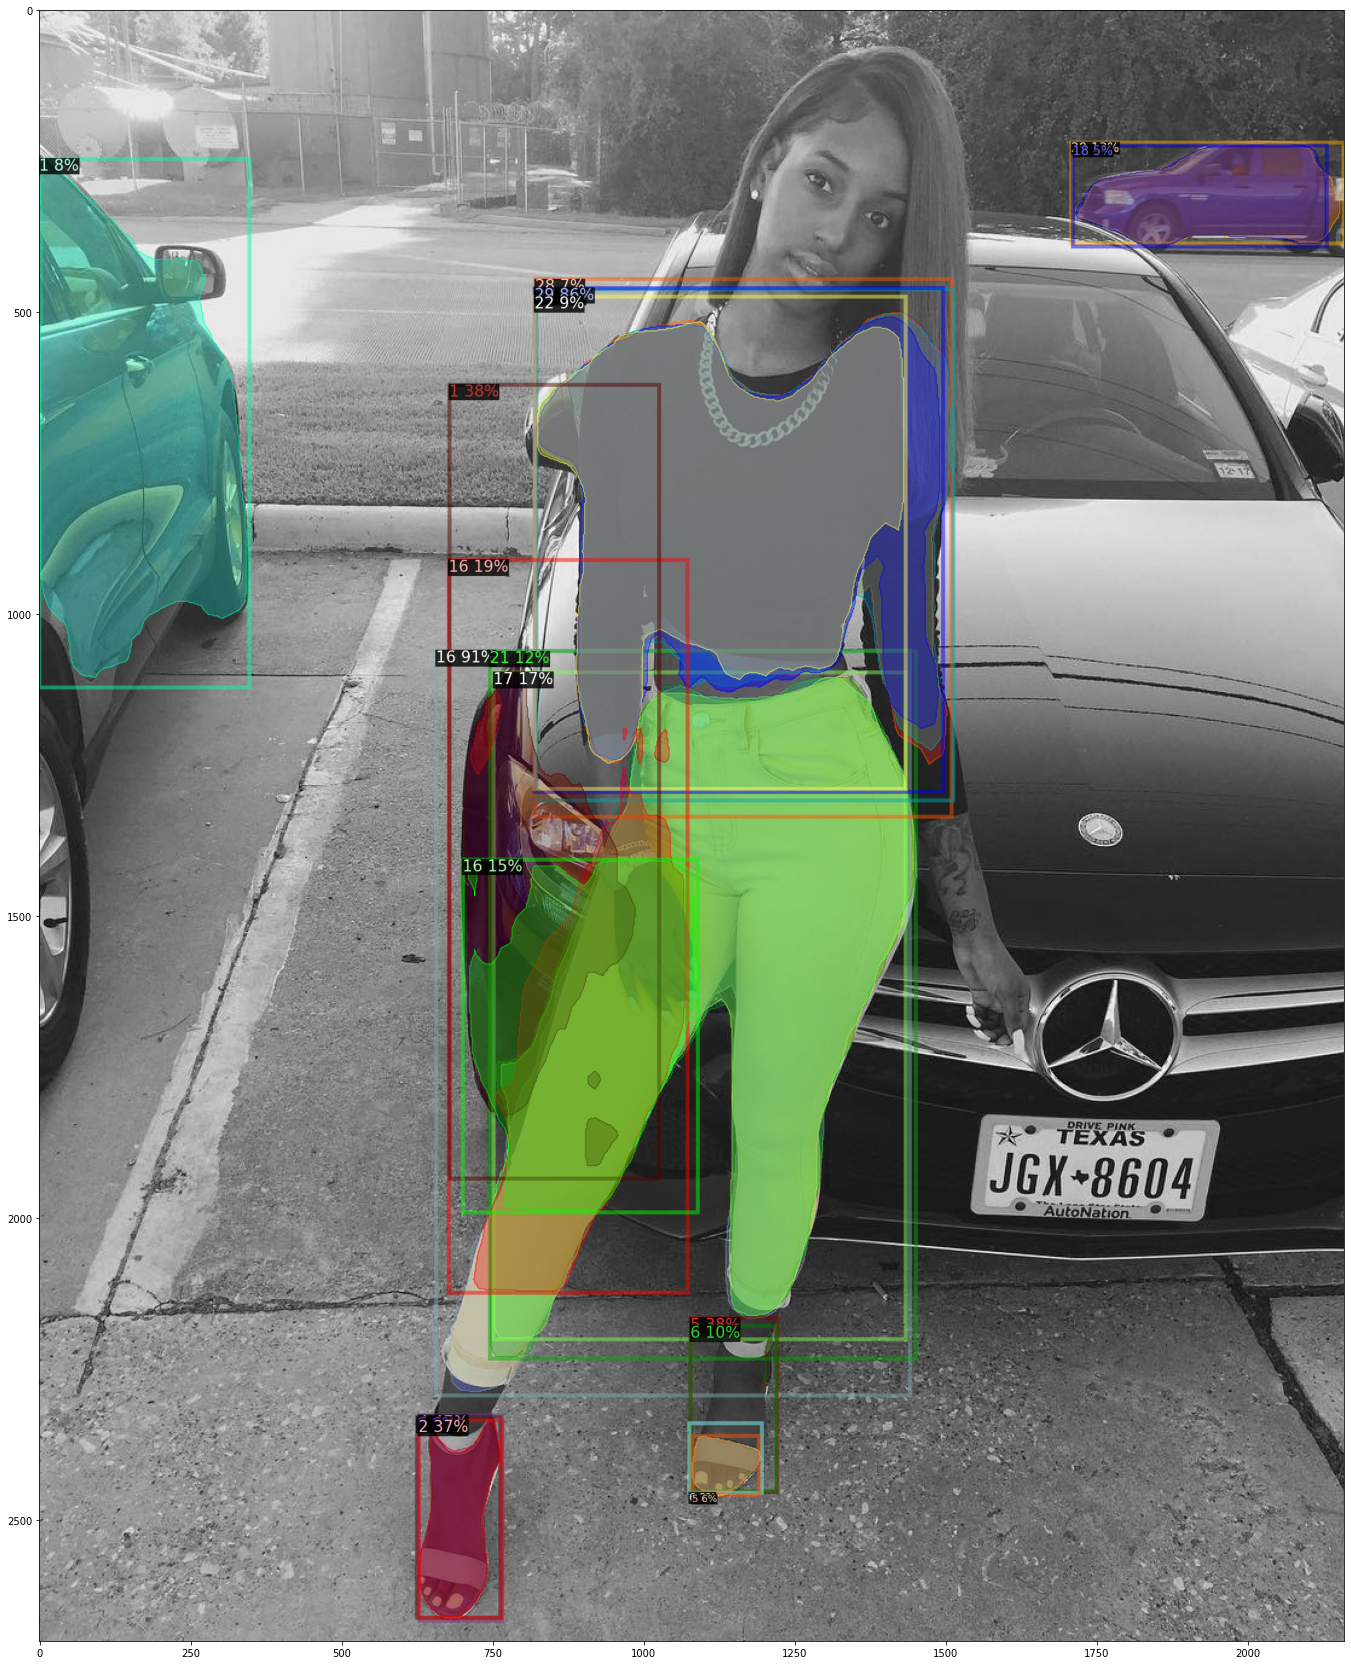

In [11]:
# Inference on 1 SINGLE IMAGE 
img = cv2.imread(img_path)
outputs = predictor(img)

# output: pred_classes, pred_boxes, pred_masks, scores
print(len(outputs["instances"].pred_classes))
print(outputs["instances"].scores)

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2, instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img_out = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
fig, ax = plt.subplots(figsize=(50,30))
plt.imshow(img_out);

In [4]:
# Inference on a WHOLE SET
# Register the TEST dataset (with annos!!)
register_coco_instances('test_set', {}, dir_te_json, dir_te)
dataset_test = DatasetCatalog.get('test_set')
meta_test = MetadataCatalog.get('test_set')

evaluator = COCOEvaluator("test_set", cfg, False, output_dir="./")
data_loader = build_detection_test_loader(cfg, "test_set")
results = inference_on_dataset(predictor.model, data_loader, evaluator)
print_csv_format(results)

[02/04 01:42:10 d2.data.datasets.coco]: Loaded 500 images in COCO format from /Users/francescabianchessi/THESIS/CODE_TESI/coco_dlcv_test_500.json
WARNING [02/04 01:42:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/04 01:42:10 d2.data.datasets.coco]: Loaded 500 images in COCO format from /Users/francescabianchessi/THESIS/CODE_TESI/coco_dlcv_test_500.json
[02/04 01:42:11 d2.data.build]: Distribution of instances among all 30 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    hat     | 136          |    bag     | 46           |   boots    | 18           |
|  slippers  | 0            |  sneakers  | 253          |   heels    | 9            |
| flat_shoes | 25           |  swimsuit  | 1            |  bathrobe  | 0            |
| underwear  | 0         

/Users/francescabianchessi/opt/anaconda3/envs/envcdec/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/04 01:42:54 d2.evaluation.evaluator]: Inference done 1/500. Dataloading: 32.2905 s/iter. Inference: 10.7117 s/iter. Eval: 0.0408 s/iter. Total: 43.0444 s/iter. ETA=5:57:59
[02/04 01:43:01 d2.evaluation.evaluator]: Inference done 2/500. Dataloading: 16.1457 s/iter. Inference: 9.0655 s/iter. Eval: 0.0277 s/iter. Total: 25.2403 s/iter. ETA=3:29:29
[02/04 01:43:13 d2.evaluation.evaluator]: Inference done 3/500. Dataloading: 10.7642 s/iter. Inference: 10.0190 s/iter. Eval: 0.0294 s/iter. Total: 20.8137 s/iter. ETA=2:52:24
[02/04 01:43:23 d2.evaluation.evaluator]: Inference done 4/500. Dataloading: 8.0734 s/iter. Inference: 9.9404 s/iter. Eval: 0.0244 s/iter. Total: 18.0394 s/iter. ETA=2:29:07
[02/04 01:43:32 d2.evaluation.evaluator]: Inference done 5/500. Dataloading: 6.4592 s/iter. Inference: 9.7383 s/iter. Eval: 0.0315 s/iter. Total: 16.2301 s/iter. ETA=2:13:53
[02/04 01:43:40 d2.evaluation.evaluator]: Inference done 6/500. Dataloading: 0.0000 s/iter. Inference: 7.9520 s/iter. Eval: 0

## 6. Visualize results

In [2]:
def display_images(dataset, ids, titles=None, cols=4):
    """Display the given set of images, optionally with titles.
    Args:
        dataset: (list[dict]) output of DatasetCatalog.get()
        ids: (int/list) image ids in a list or select random ids
        titles: optional, list of titles to display with each image
        cols: (int) number of images per row
    """
    if isinstance(ids, int): 
        ids = [d['image_id'] for d in random.sample(dataset, ids)]
    elif not isinstance(ids, list):
        return 'ids must be: int or list'
    titles = titles if titles is not None else [""] * len(ids)
    rows = len(ids) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for id, title in zip(ids, titles):
        img = cv2.imread(dataset[id]['file_name'])
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(img.astype(np.uint8)[:, :, ::-1])
        i += 1
    plt.show()

def display_gt_images(dataset, metad, ids, titles=None, scale=0.5, cols=3):
    """Display the given set of images with GT, optionally with titles.
    Args:
        dataset: (list[dict]) output of DatasetCatalog.get()
        metad: output of MetadataCatalog.get()
        ids: (int/list) image ids in a list or select random ids
        titles: optional, list of titles to display with each image
        scale: scale of image wrt to figure
        cols: (int) number of images per row
    """
    if isinstance(ids, int): 
        ids = [d['image_id'] for d in random.sample(dataset, ids)]
    elif not isinstance(ids, list):
        return 'ids must be: int or list'
    titles = titles if titles is not None else [""] * len(ids)
    rows = len(ids) // cols + 1
    plt.figure(figsize=(25, 25 * rows // cols))
    i = 1
    for id, title in zip(ids, titles):
        img = cv2.imread(dataset[id]['file_name'])
        visualizer = Visualizer(img, metadata=metad, scale=scale)
        out = visualizer.draw_dataset_dict(dataset[id])
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(out.get_image()[:, :, ::-1])
        i += 1
    plt.show()

def display_pred_images(dataset, config, ids, titles=None, scale=0.5, cols=3):
    """Display the given set of images with PREDICTIONS, optionally with titles.
    Args:
        dataset: (list[dict]) output of DatasetCatalog.get(), should be TEST set
        config: CfgNode() type, its the configuration of the pretrained model with weights
        ids: (int/list) image ids in a list or select random ids
        titles: optional, list of titles to display with each image
        scale: scale of image wrt to figure
        cols: (int) number of images per row
    """
    if isinstance(ids, int): 
        ids = [d['image_id'] for d in random.sample(dataset, ids)]
    elif not isinstance(ids, list):
        return 'ids must be: int or list'
    titles = titles if titles is not None else [""] * len(ids)
    rows = len(ids) // cols + 1
    plt.figure(figsize=(25, 25 * rows // cols))
    predictor = DefaultPredictor(config)
    i = 1
    for id, title in zip(ids, titles):
        img = cv2.imread(dataset[id]['file_name'])
        result = predictor(img)
        print('Number of detected instances: ', len(result['instances'].pred_classes))
        visualizer = Visualizer(img, MetadataCatalog.get(config.DATASETS.TRAIN[0]), scale=scale, instance_mode=ColorMode.IMAGE_BW)
        out = visualizer.draw_instance_predictions(result["instances"].to("cpu"))
        img_out = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(img_out)
        i += 1
    plt.show()


def display_gt_pred_image(dataset, metad, config, ids, titles=None, scale=0.5, cols=2):
    """Display the given set of images with GT AND PREDICTIONS, optionally with titles.
    Args:
        dataset: (list[dict]) output of DatasetCatalog.get()
        metad: metadata of the corresponding dataset
        config: CfgNode() type, its the configuration of the pretrained model with weights
        ids: (int/list) image ids in a list or select random ids
        titles: optional, list of titles to display with each image
        scale: scale of image wrt to figure
        cols: (int) number of images per row
    """
    if isinstance(ids, int): 
        ids = [d['image_id'] for d in random.sample(dataset, ids)]
    elif not isinstance(ids, list):
        return 'ids must be: int or list'
    titles = titles if titles is not None else [""] * len(ids)
    rows = len(ids) // cols + 1
    plt.figure(figsize=(25, 25 * rows // cols))
    predictor = DefaultPredictor(config)
    i = 1
    for id, title in zip(ids, titles):
        img = cv2.imread(dataset[id]['file_name'])
        result = predictor(img)
        print('Number of detected instances: ', len(result['instances'].pred_classes))
        #print('Instances predicted: ', result['instances'].pred_classes)

        vis_gt = Visualizer(img, metadata=metad, scale=scale)
        out_gt = vis_gt.draw_dataset_dict(dataset[id])
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(out_gt.get_image()[:, :, ::-1])

        vis_pred = Visualizer(img, metad, scale=scale, instance_mode=ColorMode.IMAGE_BW)
        out_pred = vis_pred.draw_instance_predictions(result["instances"].to("cpu"))
        pred_img = cv2.cvtColor(out_pred.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
        plt.subplot(rows, cols, i+1)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(pred_img)


        i += 2
    plt.show()

In [3]:
# Register Test Set 
register_coco_instances('test_set', {}, dir_te_json, dir_te)
dataset_test = DatasetCatalog.get('test_set')
meta_test = MetadataCatalog.get('test_set')

[02/17 14:52:29 d2.data.datasets.coco]: Loaded 500 images in COCO format from /Users/francescabianchessi/THESIS/CODE_TESI/coco_test_500.json


In [4]:
# Choose a trained custom model
# If have model saved in a yaml file:
cfg_name = os.path.join(OUTPUT_DIR, 'model_config.yaml')
cfg = get_cfg() 
cfg.merge_from_file(cfg_name)

cfg.MODEL.WEIGHTS = os.path.join(OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5     # set a custom testing threshold  
cfg.MODEL.DEVICE = "cpu"                         # inference works also on CPU 
#cfg.DATASETS.TEST = ("df2_test",)               # if inference on whole dataset
predictor = DefaultPredictor(cfg)

Number of detected instances:  14


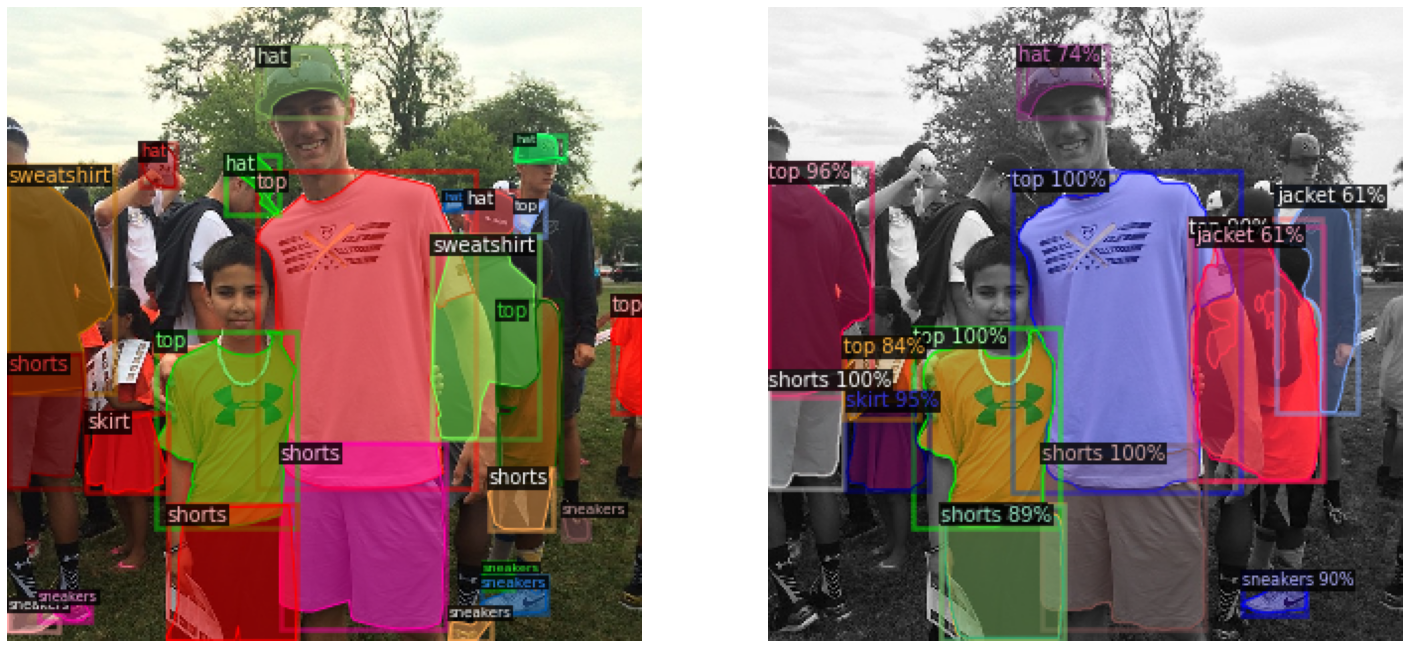

In [7]:
display_gt_pred_image(dataset_test, meta_test, cfg, [135])

Number of detected instances:  17


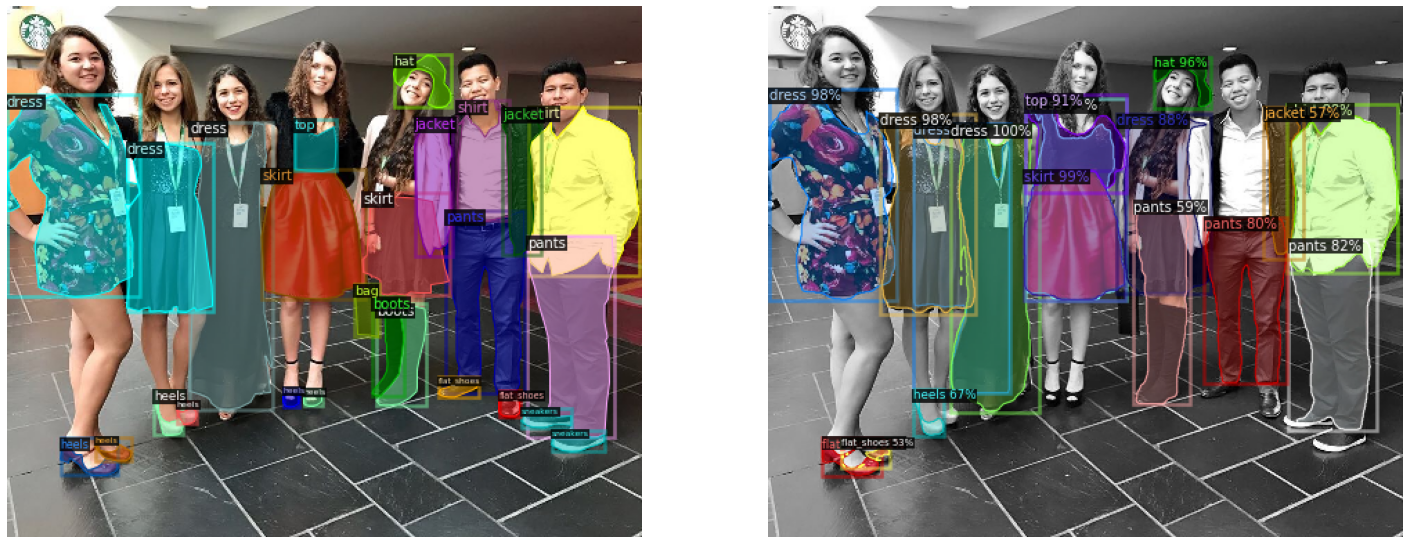

In [11]:
display_gt_pred_image(dataset_test, meta_test, cfg, [204])

Number of detected instances:  28


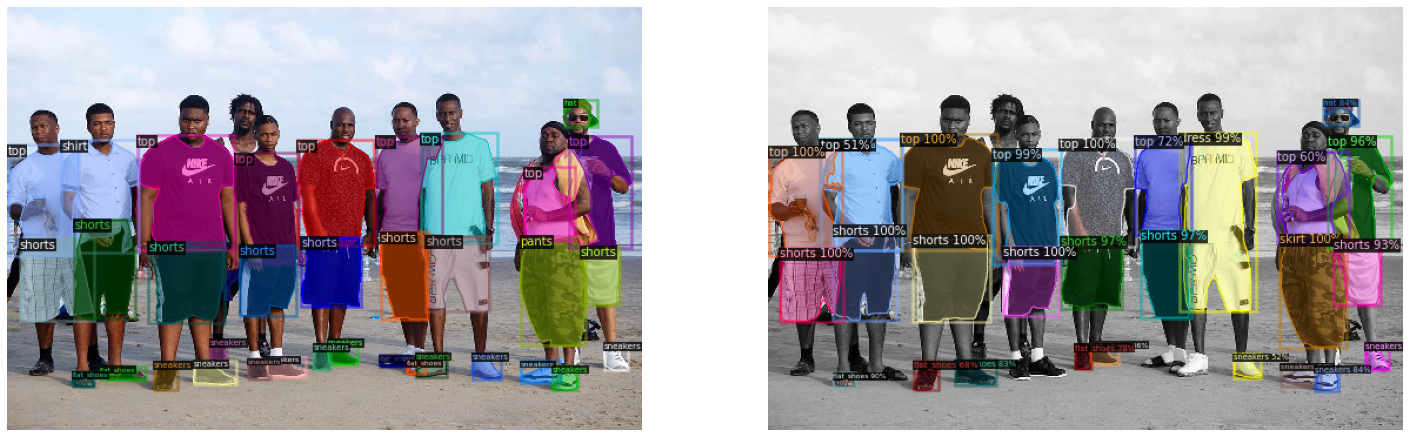

In [22]:
display_gt_pred_image(dataset_test, meta_test, cfg, [293])

Number of detected instances:  3


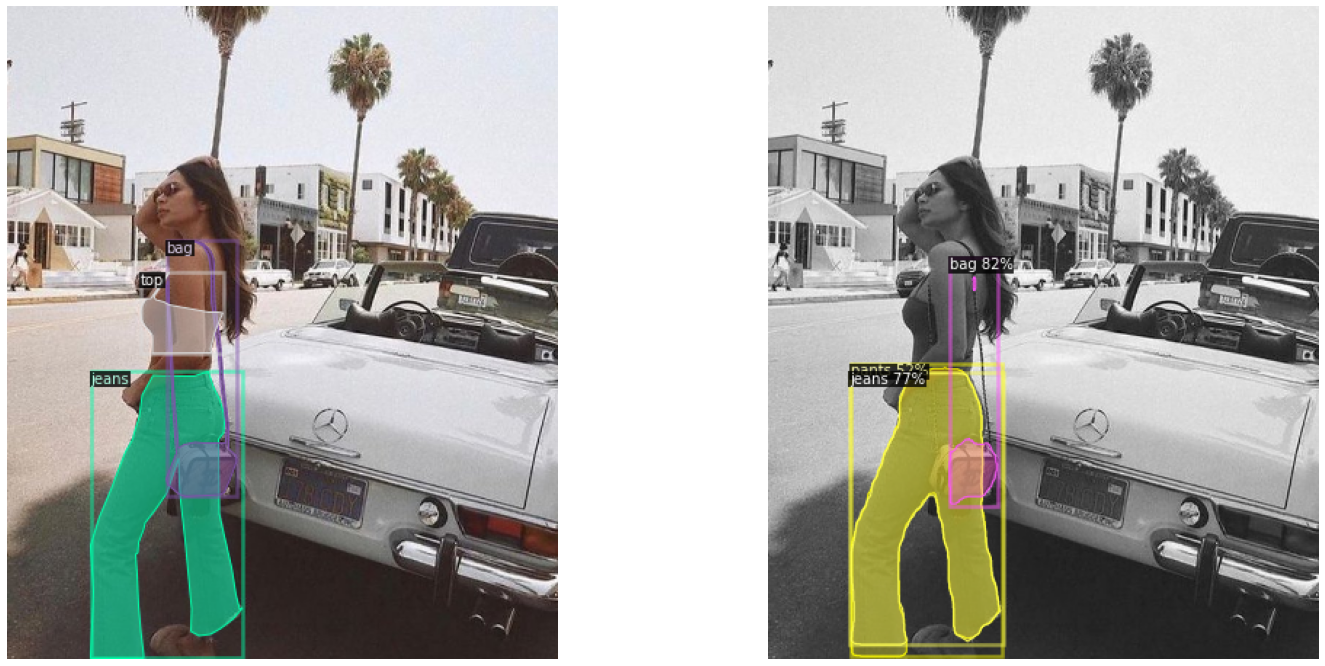

In [23]:
display_gt_pred_image(dataset_test, meta_test, cfg, [316])